In [ ]:
%reload_ext autoreload
%autoreload 2

#load libraries
import glob
import os
import json
import pandas as pd
from datetime import datetime
import numpy as np
import main_funcs as mfun

import plot_funcs as pfun

import utils_funcs as utils # utils is from Vape - catcher file: 
import LakLabAnalysis.Utility.utils_funcs as utils_laklab
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import pickle


# Get the data info
pfun.set_figure()

# Get the data info
infoPath = 'C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/infoForAnalysis.pkl'
analysis_path = 'C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/'
save_path = os.path.join(analysis_path, "populationFigures")
os.makedirs(save_path, exist_ok=True)

info = pd.read_pickle(infoPath)

## Parameters
fRate = 1000/30
responsiveness_test_duration = 1000.0 #in ms 
pre_frames    = 2000.0# in ms
pre_frames    = int(np.ceil(pre_frames/fRate))
post_frames   = 6000.0 # in ms
post_frames   = int(np.ceil(post_frames/fRate))
analysisWindowDur = 750 # in ms
analysisWindowDur = int(np.ceil(analysisWindowDur/fRate))
duration ='5'

info.recordingList

In [ ]:
# List of sessions to filter
#specific_expRefs = ['2025-05-22_1_MBL015', '2025-05-20_1_MBL015', '2025-05-14_1_MBL015']
#specific_expRefs = ['2025-06-13_3_MBL014', '2025-06-18_1_MBL014', '2025-06-19_1_MBL014']
specific_expRefs = ['2025-05-22_1_MBL015', '2025-05-20_1_MBL015', '2025-05-14_1_MBL015', '2025-06-18_1_MBL014', '2025-06-19_1_MBL014']

#specific_expRefs = ['2025-05-14_1_MBL015']

# Filter the recording list to include only the specified sessions
info.recordingList = info.recordingList[info.recordingList['sessionName'].isin(specific_expRefs)].reset_index(drop=True)
info.recordingList

create and update JSON files with recording side, bias and coords data

In [ ]:
# Create JSON file for bias data

import json
import os

# Initialize JSON file with empty dict
bias_data = {}

# Make sure the folder exists
os.makedirs(analysis_path, exist_ok=True)

# Save the file in analysis folder
json_path = os.path.join(analysis_path, 'bias_data.json')
with open(json_path, 'w') as f:
    json.dump(bias_data, f)

# Read file from that folder
with open(json_path, 'r') as f:
    data = json.load(f)

In [ ]:
# Update bias data in JSON file
json_path = os.path.join(analysis_path, 'bias_data.json')
new_bias_data = {"MBL014": "Left"}
utils.update_json_data('bias_data.json', new_bias_data, analysis_path)

# Read JSON from analysis folder
with open(json_path, 'r') as f:
    bias_data = json.load(f)

bias_data

In [ ]:
# Create JSON file for recording side data

import json
import os

# Initialize JSON file with empty dict
bias_data = {}

# Make sure the folder exists
os.makedirs(analysis_path, exist_ok=True)

# Save the file in analysis folder
json_path = os.path.join(analysis_path, 'recside_data.json')
with open(json_path, 'w') as f:
    json.dump(bias_data, f)

# Read file from that folder
with open(json_path, 'r') as f:
    data = json.load(f)

In [ ]:
# Update recording side data in JSON file
json_path = os.path.join(analysis_path, 'recside_data.json')
#new_recside_data = {"2025-05-22_1_MBL015": "Left", "2025-05-20_1_MBL015": "Right", "2025-05-16_1_MBL015": "Left", "2025-05-14_1_MBL015": "Right", "2025-05-15_1_MBL015": "Left"}
new_recside_data = {"2025-06-21_1_MBL014": "Right"}
utils.update_json_data('recside_data.json', new_recside_data, analysis_path)

# Read JSON from analysis folder
with open(json_path, 'r') as f:
    recside_data = json.load(f)

recside_data

In [ ]:
# add cols to Correctedevents csv:
#   Adds three new columns to the CSV files:
#    1. recordingSideStim: 'ipsi' if correctResponse matches recording side, else 'contra'
#    2. recordingSideChoice: 'ipsi' if choice matches recording side, else 'contra'
#    3. biasStim: 'bias' if correctResponse matches animal bias, else 'no bias'
utils.add_ipsi_contra_columns(info, analysis_path)

start extraction

In [ ]:
# MODIFIED Explore dynamics in each sessions
# For each recording one file saved, each index is a cell 

# Option to use only responsive neurons
use_responsive_only = False  # Change to False to use all neurons

pd.set_option('mode.chained_assignment', None)

for ind, recordingDate in enumerate(info.recordingList.recordingDate):

   #if (info.recordingList.imagingDataExtracted[ind]==1):
   if (info.recordingList['imagingDataExtracted'][ind]==1):
      print(str(ind) + ': Creating: ' + info.recordingList.analysispathname[ind])
      #Create a huge dictionary with all cells and parameters for each cell
      pathname = info.recordingList.analysispathname[ind]

      ########## Organise stimuli times 
      filenameCSV = info.recordingList.analysispathname[ind] + info.recordingList.sessionName[ind] + '_CorrectedeventTimes.csv'
      filenameCSV = [f for f in glob.glob(filenameCSV)]    
      behData     = pd.read_csv(filenameCSV[0], header=0)
      visTimes    = behData['stimulusOnsetTime'] + behData['trialOffsets']
      rewardTimes = behData['rewardTime'] + behData['trialOffsets']
      choice      = behData['choice']
      choiceTimes = behData['choiceStartTime'] + behData['trialOffsets']
      stimSide = behData['correctResponse']

      # make variables for new columns in behData
      recordingSideStim = behData['recordingSideStim']
      biasStim = behData['biasStim']
      recordingSideChoice = behData['recordingSideChoice']
      biasChoice = behData['biasChoice']
   
      # Make a variable for rewarded trials
      rewarded    =  behData['rewardTime'].notna() # True for rewarded which also means correct response
      # Calculate reward Time for non-rewarded Trials
      choiceCompleteTimes = behData['choiceCompleteTime'] + behData['trialOffsets']
      diff_time = np.nanmean(rewardTimes -choiceTimes)
      nan_indices = np.isnan(rewardTimes) # unrewarded trials
      rewardTimes[nan_indices] = choiceCompleteTimes[nan_indices] + diff_time
      
      # Create variable stimulus that takes the non-zero value of contrastLeft or contrastRight
      stimulus = np.where(behData['contrastLeft'] != 0, -behData['contrastLeft'], behData['contrastRight'])

      # Make a variable for stimType
      stimType = pd.Series([''] * len(behData['choice']))
      stimType [:] = 'Left'

      # Stimulus type Right
      idx_right = behData['correctResponse'] == 'Right'
      stimType[idx_right] = 'Right'
      
      # Stimulus type Zero
      idx_zero = behData['contrastRight'] - behData['contrastLeft'] == 0
      stimType[idx_zero] = 'Zero'

      # Get the stim start times 
      filenameTXT = os.path.join(info.recordingList.path[ind],'twoP') +'\*_imaging_frames.txt'
      filenameTXT= [f for f in glob.glob(filenameTXT)]    
      frame_clock = pd.read_csv(filenameTXT[0],  header= None)
         
      stimFrameTimes    = utils.stim_start_frame_Dual2Psetup (frame_clock, visTimes)
      rewardFrameTimes  = utils.stim_start_frame_Dual2Psetup (frame_clock, rewardTimes)
      choiceFrameTimes  = utils.stim_start_frame_Dual2Psetup (frame_clock, choiceTimes)

      ########## Organise calcium imaging traces 
      imData = pd.read_pickle (pathname +'imaging-data.pkl')
      fluR      = imData['flu']
      stat      = imData['stat']

      # clean detrended traces
      #flu = utils.clean_traces(fluR)
      
      flu = utils_laklab.preprocess_flu_simple(fluR, smooth_method='savgol', do_zscore=False, smooth_first=True)      

      
      # Z-score for each neuron (across time)
      flu_zscored = zscore(flu, axis=1)

      #flu_normalised = mfun.norm_to_zero_one (flu)# Explore dynamics in each sessions


      flu_normalised = zscore (fluR)
      dffTrace_reward ={} 
      dffTrace_mean_reward ={}
      dffTrace_stimuli ={} 
      dffTrace_mean_stimuli ={}
      dffTrace_choice ={}
      dffTrace_mean_choice ={}
      dff_mean_stimuli ={}
      dff_mean_reward ={}
      dff_mean_choice ={}

      ### Get dff values for 2 time windows
      tTypesName = ['Rewarded', 'Unrewarded',              # reward type
                  'Left Choices', 'Right Choices',       # choice type
                  'Rewarded Left', 'Rewarded Right',     # rewarded choice type
                  'Unrewarded Left', 'Unrewarded Right',     # unrewarded choice type
                  'Left', 'Right',                            # stimuli side type

                  '-0.0625','-0.125', '-0.25', '-0.5', '0',       # stimuli contrast type
                  '0.0625','0.125', '0.25', '0.5',

                  '-0.0625 Rewarded','-0.125 Rewarded', '-0.25 Rewarded', '-0.5 Rewarded',     # stimuli contrast type rewarded
                  '0.0625 Rewarded','0.125 Rewarded', '0.25 Rewarded', '0.5 Rewarded', '0 Rewarded',       # stimuli contrast type rewarded
                  
                  '-0.0625 Unrewarded','-0.125 Unrewarded', '-0.25 Unrewarded', '-0.5 Unrewarded',       # stimuli contrast type unrewarded
                  '0.0625 Unrewarded','0.125 Unrewarded', '0.25 Unrewarded', '0.5 Unrewarded', '0 Unrewarded',       # stimuli contrast type unrewarded                  
          
                  '-0.0625 Rewarded Hemi Ipsi','-0.125 Rewarded Hemi Ipsi', '-0.25 Rewarded Hemi Ipsi', '-0.5 Rewarded Hemi Ipsi',                   
                  '0.0625 Rewarded Hemi Ipsi','0.125 Rewarded Hemi Ipsi', '0.25 Rewarded Hemi Ipsi', '0.5 Rewarded Hemi Ipsi', '0 Rewarded Hemi Ipsi',       # stimuli contrast type rewarded ipsi
                  
                  '-0.0625 Rewarded Hemi Contra','-0.125 Rewarded Hemi Contra', '-0.25 Rewarded Hemi Contra', '-0.5 Rewarded Hemi Contra',                   
                  '0.0625 Rewarded Hemi Contra','0.125 Rewarded Hemi Contra', '0.25 Rewarded Hemi Contra', '0.5 Rewarded Hemi Contra', '0 Rewarded Hemi Contra',       # stimuli contrast type rewarded contra
                  
                  '-0.0625 Rewarded Bias Ipsi','-0.125 Rewarded Bias Ipsi', '-0.25 Rewarded Bias Ipsi', '-0.5 Rewarded Bias Ipsi',                   
                  '0.0625 Rewarded Bias Ipsi','0.125 Rewarded Bias Ipsi', '0.25 Rewarded Bias Ipsi', '0.5 Rewarded Bias Ipsi', '0 Rewarded Bias Ipsi',       # stimuli contrast type rewarded bias
                  
                  '-0.0625 Rewarded Bias Contra','-0.125 Rewarded Bias Contra', '-0.25 Rewarded Bias Contra', '-0.5 Rewarded Bias Contra',
                  '0.0625 Rewarded Bias Contra','0.125 Rewarded Bias Contra', '0.25 Rewarded Bias Contra', '0.5 Rewarded Bias Contra', '0 Rewarded Bias Contra',       # stimuli contrast type rewarded no bias
                  
                  
                  'Stim Hemi Ipsi', 'Stim Hemi Contra',        # stimuli compared to recording side
                  'Stim Bias Ipsi', 'Stim Bias Contra',         # stimuli compared to bias   
                  
                  'Choice Bias Ipsi', 'Choice Bias Contra',     # choice compared to bias
                  'Choice Hemi Ipsi', 'Choice Hemi Contra'   # choice compared to recording side
                  ]
      tTypes = [(rewarded==True),(rewarded!=True),          # reward type
                
               (choice == 'Left'),(choice == 'Right'),      # choice type

               (rewarded==True) & (choice == 'Left'),       # rewarded choice type
               (rewarded==True) & (choice == 'Right'),      # rewarded choice type

               (rewarded!=True) & (choice == 'Left'),       # unrewarded choice type
               (rewarded!=True) & (choice == 'Right'),      # unrewarded choice type

               (stimSide == 'Left'),(stimSide == 'Right'),  # stimuli side type
                           
               (stimulus == -0.0625),(stimulus == -0.125),    # stimuli contrast type
               (stimulus == -0.25),(stimulus == -0.5),        # stimuli contrast type
               (stimulus == 0),                             # stimuli contrast type
               (stimulus == 0.0625),(stimulus == 0.125),    # stimuli contrast type
               (stimulus == 0.25),(stimulus == 0.5),        # stimuli contrast type

               (rewarded==True) & (stimulus == -0.0625),     # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == -0.125),      # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == -0.25),      # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == -0.5),      # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == 0.0625),     # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == 0.125),      # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == 0.25),      # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == 0.5),      # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == 0),      # stimuli contrast type rewarded 0

               (rewarded!=True) & (stimulus == -0.0625),     # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == -0.125),      # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == -0.25),      # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == -0.5),      # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == 0.0625),     # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == 0.125),      # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == 0.25),      # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == 0.5),      # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == 0),      # stimuli contrast type unrewarded

               (recordingSideStim == 'ipsi') & (stimulus == -0.0625) & (rewarded==True),     # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == -0.125) & (rewarded==True),      # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == -0.25) & (rewarded==True),      # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == -0.5) & (rewarded==True),      # stimuli contrast type rewarded ipsi

               (recordingSideStim == 'ipsi') & (stimulus == 0.0625) & (rewarded==True),     # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == 0.125) & (rewarded==True),      # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == 0.25) & (rewarded==True),      # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == 0.5) & (rewarded==True),      # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == 0) & (rewarded==True),      # stimuli contrast type rewarded ipsi

               (recordingSideStim == 'contra') & (stimulus == -0.0625) & (rewarded==True),     # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == -0.125) & (rewarded==True),      # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == -0.25) & (rewarded==True),      # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == -0.5) & (rewarded==True),      # stimuli contrast type rewarded contra

               (recordingSideStim == 'contra') & (stimulus == 0.0625) & (rewarded==True),     # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == 0.125) & (rewarded==True),      # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == 0.25) & (rewarded==True),      # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == 0.5) & (rewarded==True),      # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == 0) & (rewarded==True),      # stimuli contrast type rewarded contra

               (biasStim == 'bias') & (stimulus == -0.0625) & (rewarded==True),     # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == -0.125) & (rewarded==True),      # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == -0.25) & (rewarded==True),      # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == -0.5) & (rewarded==True),      # stimuli contrast type rewarded bias

               (biasStim == 'bias') & (stimulus == 0.0625) & (rewarded==True),     # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == 0.125) & (rewarded==True),      # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == 0.25) & (rewarded==True),      # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == 0.5) & (rewarded==True),      # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == 0) & (rewarded==True),      # stimuli contrast type rewarded bias

               (biasStim == 'no bias') & (stimulus == -0.0625) & (rewarded==True),     # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == -0.125) & (rewarded==True),      # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == -0.25) & (rewarded==True),      # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == -0.5) & (rewarded==True),      # stimuli contrast type rewarded no bias

               (biasStim == 'no bias') & (stimulus == 0.0625) & (rewarded==True),     # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == 0.125) & (rewarded==True),      # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == 0.25) & (rewarded==True),      # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == 0.5) & (rewarded==True),      # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == 0) & (rewarded==True),      # stimuli contrast type rewarded no bias

               (recordingSideStim == 'ipsi'),              # stimuli compared to recording side
               (recordingSideStim == 'contra'),             # stimuli compared to recording side

               (biasStim == 'bias'),                    # stimuli compared to bias
               (biasStim == 'no bias'),                  # stimuli compared to bias

               (biasChoice == 'bias'),                    # choice compared to bias
               (biasChoice == 'no bias'),                  # choice compared to bias

               (recordingSideChoice == 'ipsi'),            # choice compared to recording side
               (recordingSideChoice == 'contra')           # choice compared to recording side
               ]


      for indx, t in enumerate(tTypesName):
         # For reward
         selected_indices = [rewardFrameTimes[i] for i in np.where((tTypes[indx]==True)& (~np.isnan(rewardFrameTimes)))[0]]  
         selected_indices = [value for value in selected_indices if value == value]
         dffTrace_reward[t] = utils.flu_splitter(flu,selected_indices, pre_frames, post_frames)  # Cell x time x trial
         dffTrace_mean_reward[t] = np.mean(dffTrace_reward[t],2) if len(selected_indices)>2 else None # Cell x time
         dff_mean_reward[t] = np.nanmean(dffTrace_mean_reward[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None
         
         # For stimuli
         selected_indices = [stimFrameTimes[i] for i in np.where(tTypes[indx]==True)[0]]
         selected_indices = [value for value in selected_indices if value == value]
         dffTrace_stimuli[t] = utils.flu_splitter(flu, selected_indices, pre_frames, post_frames) # Cell x time x trial 
         dffTrace_mean_stimuli[t] = np.mean(dffTrace_stimuli[t],2) if len(selected_indices)>2 else None # Cell x time
         dff_mean_stimuli[t] = np.nanmean(dffTrace_mean_stimuli[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None

         # For choice
         selected_indices = [choiceFrameTimes[i] for i in np.where((tTypes[indx]==True)& (~np.isnan(choiceFrameTimes)))[0]] 
         selected_indices = [value for value in selected_indices if value == value]
         dffTrace_choice[t] = utils.flu_splitter(flu, selected_indices, pre_frames, post_frames) # Cell x time x trial
         dffTrace_mean_choice[t] = np.mean(dffTrace_choice[t],2) if len(selected_indices)>2 else None # Cell x time
         dff_mean_choice[t] = np.nanmean(dffTrace_mean_choice[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None

      # --- Z-SCORED ---
         dffTrace_reward_z = {}
         dffTrace_mean_reward_z = {}
         dffTrace_stimuli_z = {}
         dffTrace_mean_stimuli_z = {}
         dffTrace_choice_z = {}
         dffTrace_mean_choice_z = {}
         dff_mean_stimuli_z = {}
         dff_mean_reward_z = {}
         dff_mean_choice_z = {}

         for indx, t in enumerate(tTypesName):
            # Reward
            selected_indices = [rewardFrameTimes[i] for i in np.where((tTypes[indx]==True)& (~np.isnan(rewardFrameTimes)))[0]]  
            selected_indices = [value for value in selected_indices if value == value]
            dffTrace_reward_z[t] = utils.flu_splitter(flu_zscored, selected_indices, pre_frames, post_frames)
            dffTrace_mean_reward_z[t] = np.mean(dffTrace_reward_z[t],2) if len(selected_indices)>2 else None
            dff_mean_reward_z[t] = np.nanmean(dffTrace_mean_reward_z[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None

            # Stimuli
            selected_indices = [stimFrameTimes[i] for i in np.where(tTypes[indx]==True)[0]]
            selected_indices = [value for value in selected_indices if value == value]
            dffTrace_stimuli_z[t] = utils.flu_splitter(flu_zscored, selected_indices, pre_frames, post_frames)
            dffTrace_mean_stimuli_z[t] = np.mean(dffTrace_stimuli_z[t],2) if len(selected_indices)>2 else None
            dff_mean_stimuli_z[t] = np.nanmean(dffTrace_mean_stimuli_z[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None

            # Choice
            selected_indices = [choiceFrameTimes[i] for i in np.where((tTypes[indx]==True)& (~np.isnan(choiceFrameTimes)))[0]] 
            selected_indices = [value for value in selected_indices if value == value]
            dffTrace_choice_z[t] = utils.flu_splitter(flu_zscored, selected_indices, pre_frames, post_frames)
            dffTrace_mean_choice_z[t] = np.mean(dffTrace_choice_z[t],2) if len(selected_indices)>2 else None
            dff_mean_choice_z[t] = np.nanmean(dffTrace_mean_choice_z[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None


      ##################
      # Filter significantly responsive neurons for each alignment type
      
      if use_responsive_only:
         # --- Responsive filter for stimuli ---
         responsive_neurons_stimuli = utils.filter_responsive_neurons(dffTrace_mean_stimuli, pre_frames, post_frames)
         responsive_any_stimuli = None
         for cond, mask in responsive_neurons_stimuli.items():
            if mask is not None:
                  if responsive_any_stimuli is None:
                     responsive_any_stimuli = mask.copy()
                  else:
                     responsive_any_stimuli = responsive_any_stimuli | mask
         print(f'Filtering globally responsive neurons for stimuli ({np.sum(responsive_any_stimuli)} neurons)')
         for condition in dffTrace_mean_stimuli.keys():
            if dffTrace_mean_stimuli[condition] is not None and responsive_any_stimuli is not None:
                  dffTrace_stimuli[condition] = dffTrace_stimuli[condition][responsive_any_stimuli]
                  dffTrace_mean_stimuli[condition] = dffTrace_mean_stimuli[condition][responsive_any_stimuli]
                  dff_mean_stimuli[condition] = dff_mean_stimuli[condition][responsive_any_stimuli]
                  if 'dffTrace_stimuli_z' in locals() and dffTrace_stimuli_z.get(condition) is not None:
                     dffTrace_stimuli_z[condition] = dffTrace_stimuli_z[condition][responsive_any_stimuli]
                  if 'dffTrace_mean_stimuli_z' in locals() and dffTrace_mean_stimuli_z.get(condition) is not None:
                     dffTrace_mean_stimuli_z[condition] = dffTrace_mean_stimuli_z[condition][responsive_any_stimuli]
                  if 'dff_mean_stimuli_z' in locals() and dff_mean_stimuli_z.get(condition) is not None:
                     dff_mean_stimuli_z[condition] = dff_mean_stimuli_z[condition][responsive_any_stimuli]

         # --- Responsive filter for choice ---
         responsive_neurons_choice = utils.filter_responsive_neurons(dffTrace_mean_choice, pre_frames, post_frames)
         responsive_any_choice = None
         for cond, mask in responsive_neurons_choice.items():
            if mask is not None:
                  if responsive_any_choice is None:
                     responsive_any_choice = mask.copy()
                  else:
                     responsive_any_choice = responsive_any_choice | mask
         print(f'Filtering globally responsive neurons for choice ({np.sum(responsive_any_choice)} neurons)')
         for condition in dffTrace_mean_choice.keys():
            if dffTrace_mean_choice[condition] is not None and responsive_any_choice is not None:
                  dffTrace_choice[condition] = dffTrace_choice[condition][responsive_any_choice]
                  dffTrace_mean_choice[condition] = dffTrace_mean_choice[condition][responsive_any_choice]
                  dff_mean_choice[condition] = dff_mean_choice[condition][responsive_any_choice]
                  if 'dffTrace_choice_z' in locals() and dffTrace_choice_z.get(condition) is not None:
                     dffTrace_choice_z[condition] = dffTrace_choice_z[condition][responsive_any_choice]
                  if 'dffTrace_mean_choice_z' in locals() and dffTrace_mean_choice_z.get(condition) is not None:
                     dffTrace_mean_choice_z[condition] = dffTrace_mean_choice_z[condition][responsive_any_choice]
                  if 'dff_mean_choice_z' in locals() and dff_mean_choice_z.get(condition) is not None:
                     dff_mean_choice_z[condition] = dff_mean_choice_z[condition][responsive_any_choice]

         # --- Responsive filter for reward ---
         responsive_neurons_reward = utils.filter_responsive_neurons(dffTrace_mean_reward, pre_frames, post_frames)
         responsive_any_reward = None
         for cond, mask in responsive_neurons_reward.items():
            if mask is not None:
                  if responsive_any_reward is None:
                     responsive_any_reward = mask.copy()
                  else:
                     responsive_any_reward = responsive_any_reward | mask
         print(f'Filtering globally responsive neurons for reward ({np.sum(responsive_any_reward)} neurons)')
         for condition in dffTrace_mean_reward.keys():
            if dffTrace_mean_reward[condition] is not None and responsive_any_reward is not None:
                  dffTrace_reward[condition] = dffTrace_reward[condition][responsive_any_reward]
                  dffTrace_mean_reward[condition] = dffTrace_mean_reward[condition][responsive_any_reward]
                  dff_mean_reward[condition] = dff_mean_reward[condition][responsive_any_reward]
                  if 'dffTrace_reward_z' in locals() and dffTrace_reward_z.get(condition) is not None:
                     dffTrace_reward_z[condition] = dffTrace_reward_z[condition][responsive_any_reward]
                  if 'dffTrace_mean_reward_z' in locals() and dffTrace_mean_reward_z.get(condition) is not None:
                     dffTrace_mean_reward_z[condition] = dffTrace_mean_reward_z[condition][responsive_any_reward]
                  if 'dff_mean_reward_z' in locals() and dff_mean_reward_z.get(condition) is not None:
                     dff_mean_reward_z[condition] = dff_mean_reward_z[condition][responsive_any_reward]

      ###################

      # Determine subfolder based on use_responsive_only
      subfolder = 'responsive_neurons' if use_responsive_only else 'all_neurons'
      subfolder_path = os.path.join(pathname, subfolder)
      os.makedirs(subfolder_path, exist_ok=True)

      # Save params in the appropriate subfolder
      filenameINFO = os.path.join(subfolder_path, 'imaging-dffTrace.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dffTrace_reward,dffTrace_stimuli, dffTrace_choice] , f)

      filenameINFO = os.path.join(subfolder_path, 'imaging-dffTrace_mean.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dffTrace_mean_reward,
                     dffTrace_mean_stimuli,
                     dffTrace_mean_choice ] , f)

      filenameINFO = os.path.join(subfolder_path, 'imaging-dff_mean.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dff_mean_reward,
                     dff_mean_stimuli,
                     dff_mean_choice ] , f)

      # Save z-scored data in the same subfolder
      filenameINFO = os.path.join(subfolder_path, 'imaging-dffTrace_zscored.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dffTrace_reward_z, dffTrace_stimuli_z, dffTrace_choice_z], f)

      filenameINFO = os.path.join(subfolder_path, 'imaging-dffTrace_mean_zscored.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dffTrace_mean_reward_z, dffTrace_mean_stimuli_z, dffTrace_mean_choice_z], f)

      filenameINFO = os.path.join(subfolder_path, 'imaging-dff_mean_zscored.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dff_mean_reward_z, dff_mean_stimuli_z, dff_mean_choice_z], f)

      
      # Heat Plots
      colormap = 'viridis'
      selectedSession = 'WithinSession'
      
      savefigname = 'SessionComparison-heatmap-reward_' + str(duration[0]) + 'sec'
      analysis_params = ['Rewarded', 'Unrewarded']
      pfun.heatmap_sessions(dffTrace_mean_reward, analysis_params, colormap,
                           selectedSession, duration, savefigname, subfolder_path) 
      plt.close()
                     
      savefigname = 'SessionComparison-heatmap-choice_' + str(duration[0]) + 'sec'
      analysis_params = ['Left Choices','Right Choices']
      pfun.heatmap_sessions(dffTrace_mean_choice, analysis_params, colormap,
                           selectedSession, duration, savefigname, subfolder_path) 
      plt.close()

      savefigname = 'SessionComparison-heatmap-stimuli_' + str(duration[0]) + 'sec'
      analysis_params = ['0.0625','0.125', '0.25', '0.5', '0']
      pfun.heatmap_sessions(dffTrace_mean_stimuli, analysis_params, colormap,
                           selectedSession, duration, savefigname, subfolder_path) 
      plt.close()


     # Mean Plots 
      zscoreRun = False 
      baseline_subtract = [-1.0, 0.0]  # Baseline window: 1 second before stimulus onset

      # Get animal number and session info
      session_name = info.recordingList.sessionName[ind]
      title_prefix = f'{session_name}'

      colormap = ['red', 'black']
      savefigname = 'SessionComparison-mean-reward_' + str(duration[0]) + 'sec'
      analysis_params = ['Rewarded', 'Unrewarded']
      pfun.lineplot_sessions(dffTrace_mean_reward, analysis_params, colormap,
                           duration, zscoreRun, savefigname, subfolder_path, baseline_subtract, 
                           title=f'{title_prefix} - Rewarded vs Unrewarded / reward aligned') 
      plt.close()

      colormap = ['blue', 'red']
      savefigname = 'SessionComparison-mean-choice_' + str(duration[0]) + 'sec'
      analysis_params = ['Left Choices','Right Choices']
      pfun.lineplot_sessions(dffTrace_mean_choice, analysis_params, colormap,
                           duration, zscoreRun, savefigname, subfolder_path, baseline_subtract,
                           title=f'{title_prefix} - Choice side / choice aligned')
      plt.close()

      colormap = 'viridis'
      savefigname = 'SessionComparison-mean-stimuli-rewarded-contrasts_' + str(duration[0]) + 'sec'
      analysis_params = ['0.5 Rewarded', '0.25 Rewarded','0.125 Rewarded','0.0625 Rewarded','0 Rewarded']
      pfun.lineplot_sessions(dffTrace_mean_stimuli, analysis_params, colormap,
                           duration, zscoreRun, savefigname, subfolder_path, baseline_subtract,
                           title=f'{title_prefix} - Rewarded stimuli / stimulus aligned') 
      plt.close()

      colormap = 'viridis'
      savefigname = 'SessionComparison-mean-reward-rewarded-contrasts_' + str(duration[0]) + 'sec'
      analysis_params = ['0.5 Rewarded', '0.25 Rewarded','0.125 Rewarded','0.0625 Rewarded','0 Rewarded']
      pfun.lineplot_sessions(dffTrace_mean_reward, analysis_params, colormap,
                           duration, zscoreRun, savefigname, subfolder_path, baseline_subtract,
                           title=f'{title_prefix} - Rewarded stimuli / reward aligned') 
      plt.close()

      colormap = ['blue', 'red']
      savefigname = 'SessionComparison-mean-stimuli_' + str(duration[0]) + 'sec'
      analysis_params = ['Left','Right']
      pfun.lineplot_sessions(dffTrace_mean_stimuli, analysis_params, colormap,
                           duration, zscoreRun, savefigname, subfolder_path, baseline_subtract,
                           title=f'{title_prefix} - Stimuli side / stimulus aligned') 
      plt.close()

      print('Completed')
      info.recordingList.loc[ind,'analysisVariableExtracted'] = 0 


In [ ]:
# Explore dynamics in each sessions
# For each recording one file saved, each index is a cell 

# Option to use only responsive neurons
use_responsive_only = True  # Change to False to use all neurons

pd.set_option('mode.chained_assignment', None)

for ind, recordingDate in enumerate(info.recordingList.recordingDate):

   #if (info.recordingList.imagingDataExtracted[ind]==1):
   if (info.recordingList['imagingDataExtracted'][ind]==1):
      print(str(ind) + ': Creating: ' + info.recordingList.analysispathname[ind])
      #Create a huge dictionary with all cells and parameters for each cell
      pathname = info.recordingList.analysispathname[ind]

      ########## Organise stimuli times 
      filenameCSV = info.recordingList.analysispathname[ind] + info.recordingList.sessionName[ind] + '_CorrectedeventTimes.csv'
      filenameCSV = [f for f in glob.glob(filenameCSV)]    
      behData     = pd.read_csv(filenameCSV[0], header=0)
      visTimes    = behData['stimulusOnsetTime'] + behData['trialOffsets']
      rewardTimes = behData['rewardTime'] + behData['trialOffsets']
      choice      = behData['choice']
      choiceTimes = behData['choiceStartTime'] + behData['trialOffsets']
      stimSide = behData['correctResponse']

      # make variables for new columns in behData
      recordingSideStim = behData['recordingSideStim']
      biasStim = behData['biasStim']
      recordingSideChoice = behData['recordingSideChoice']
      biasChoice = behData['biasChoice']
   
      # Make a variable for rewarded trials
      rewarded    =  behData['rewardTime'].notna() # True for rewarded which also means correct response
      # Calculate reward Time for non-rewarded Trials
      choiceCompleteTimes = behData['choiceCompleteTime'] + behData['trialOffsets']
      diff_time = np.nanmean(rewardTimes -choiceTimes)
      nan_indices = np.isnan(rewardTimes) # unrewarded trials
      rewardTimes[nan_indices] = choiceCompleteTimes[nan_indices] + diff_time
      
      # Create variable stimulus that takes the non-zero value of contrastLeft or contrastRight
      stimulus = np.where(behData['contrastLeft'] != 0, behData['contrastLeft'], behData['contrastRight'])

      # Make a variable for stimType
      stimType = pd.Series([''] * len(behData['choice']))
      stimType [:] = 'Left'

      # Stimulus type Right
      idx_right = behData['correctResponse'] == 'Right'
      stimType[idx_right] = 'Right'
      
      # Stimulus type Zero
      idx_zero = behData['contrastRight'] - behData['contrastLeft'] == 0
      stimType[idx_zero] = 'Zero'

      # Get the stim start times 
      filenameTXT = os.path.join(info.recordingList.path[ind],'twoP') +'\*_imaging_frames.txt'
      filenameTXT= [f for f in glob.glob(filenameTXT)]    
      frame_clock = pd.read_csv(filenameTXT[0],  header= None)
         
      stimFrameTimes    = utils.stim_start_frame_Dual2Psetup (frame_clock, visTimes)
      rewardFrameTimes  = utils.stim_start_frame_Dual2Psetup (frame_clock, rewardTimes)
      choiceFrameTimes  = utils.stim_start_frame_Dual2Psetup (frame_clock, choiceTimes)

      ########## Organise calcium imaging traces 
      imData = pd.read_pickle (pathname +'imaging-data.pkl')
      fluR      = imData['flu']
      stat      = imData['stat']

      # clean detrended traces
      #flu = utils.clean_traces(fluR)
      
      flu = utils_laklab.preprocess_flu_simple(fluR, smooth_method='savgol', do_zscore=False, smooth_first=True)      

      
      # Z-score for each neuron (across time)
      flu_zscored = zscore(flu, axis=1)

      #flu_normalised = mfun.norm_to_zero_one (flu)# Explore dynamics in each sessions


      flu_normalised = zscore (fluR)
      dffTrace_reward ={} 
      dffTrace_mean_reward ={}
      dffTrace_stimuli ={} 
      dffTrace_mean_stimuli ={}
      dffTrace_choice ={}
      dffTrace_mean_choice ={}
      dff_mean_stimuli ={}
      dff_mean_reward ={}
      dff_mean_choice ={}

      ### Get dff values for 2 time windows
      tTypesName = ['Rewarded', 'Unrewarded',              # reward type
                  'Left Choices', 'Right Choices',       # choice type
                  'Rewarded Left', 'Rewarded Right',     # rewarded choice type
                  'Unrewarded Left', 'Unrewarded Right',     # unrewarded choice type
                  'Left', 'Right',                            # stimuli side type
                  '0.0625','0.125', '0.25', '0.5', '0',       # stimuli contrast type

                  '0.0625 Rewarded','0.125 Rewarded', '0.25 Rewarded', '0.5 Rewarded', '0 Rewarded',       # stimuli contrast type rewarded
                  '0.0625 Unrewarded','0.125 Unrewarded', '0.25 Unrewarded', '0.5 Unrewarded', '0 Unrewarded',       # stimuli contrast type unrewarded
                  
                  '0.0625 Rewarded Left','0.125 Rewarded Left', '0.25 Rewarded Left', '0.5 Rewarded Left', '0 Rewarded Left',       # stimuli contrast type rewarded
                  '0.0625 Rewarded Right','0.125 Rewarded Right', '0.25 Rewarded Right', '0.5 Rewarded Right', '0 Rewarded Right',       # stimuli contrast type rewarded
                  
                  '0.0625 Rewarded Hemi Ipsi','0.125 Rewarded Hemi Ipsi', '0.25 Rewarded Hemi Ipsi', '0.5 Rewarded Hemi Ipsi', '0 Rewarded Hemi Ipsi',       # stimuli contrast type rewarded ipsi
                  '0.0625 Rewarded Hemi Contra','0.125 Rewarded Hemi Contra', '0.25 Rewarded Hemi Contra', '0.5 Rewarded Hemi Contra', '0 Rewarded Hemi Contra',       # stimuli contrast type rewarded contra
                  
                  '0.0625 Rewarded Bias Ipsi','0.125 Rewarded Bias Ipsi', '0.25 Rewarded Bias Ipsi', '0.5 Rewarded Bias Ipsi', '0 Rewarded Bias Ipsi',       # stimuli contrast type rewarded bias
                  '0.0625 Rewarded Bias Contra','0.125 Rewarded Bias Contra', '0.25 Rewarded Bias Contra', '0.5 Rewarded Bias Contra', '0 Rewarded Bias Contra',       # stimuli contrast type rewarded no bias
                  
                  
                  'Stim Hemi Ipsi', 'Stim Hemi Contra',        # stimuli compared to recording side
                  'Stim Bias Ipsi', 'Stim Bias Contra',         # stimuli compared to bias   
                  
                  'Choice Bias Ipsi', 'Choice Bias Contra',     # choice compared to bias
                  'Choice Hemi Ipsi', 'Choice Hemi Contra'   # choice compared to recording side
                  ]
      tTypes = [(rewarded==True),(rewarded!=True),          # reward type
                
               (choice == 'Left'),(choice == 'Right'),      # choice type

               (rewarded==True) & (choice == 'Left'),       # rewarded choice type
               (rewarded==True) & (choice == 'Right'),      # rewarded choice type

               (rewarded!=True) & (choice == 'Left'),       # unrewarded choice type
               (rewarded!=True) & (choice == 'Right'),      # unrewarded choice type

               (stimSide == 'Left'),(stimSide == 'Right'),  # stimuli side type
                           
               (stimulus == 0.0625),(stimulus == 0.125),    # stimuli contrast type
               (stimulus == 0.25),(stimulus == 0.5),        # stimuli contrast type
               (stimulus == 0),                             # stimuli contrast type

               (rewarded==True) & (stimulus == 0.0625),     # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == 0.125),      # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == 0.25),      # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == 0.5),      # stimuli contrast type rewarded
               (rewarded==True) & (stimulus == 0),      # stimuli contrast type rewarded

               (rewarded!=True) & (stimulus == 0.0625),     # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == 0.125),      # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == 0.25),      # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == 0.5),      # stimuli contrast type unrewarded
               (rewarded!=True) & (stimulus == 0),      # stimuli contrast type unrewarded

               (stimSide == 'Left') & (stimulus == 0.0625) & (rewarded==True),     # stimuli contrast type rewarded left
               (stimSide == 'Left') & (stimulus == 0.125) & (rewarded==True),      # stimuli contrast type rewarded left
               (stimSide == 'Left') & (stimulus == 0.25) & (rewarded==True),      # stimuli contrast type rewarded left
               (stimSide == 'Left') & (stimulus == 0.5) & (rewarded==True),      # stimuli contrast type rewarded left
               (stimSide == 'Left') & (stimulus == 0) & (rewarded==True),      # stimuli contrast type rewarded left

               (stimSide == 'Right') & (stimulus == 0.0625) & (rewarded==True),     # stimuli contrast type rewarded right
               (stimSide == 'Right') & (stimulus == 0.125) & (rewarded==True),      # stimuli contrast type rewarded right
               (stimSide == 'Right') & (stimulus == 0.25) & (rewarded==True),      # stimuli contrast type rewarded right
               (stimSide == 'Right') & (stimulus == 0.5) & (rewarded==True),      # stimuli contrast type rewarded right
               (stimSide == 'Right') & (stimulus == 0) & (rewarded==True),      # stimuli contrast type rewarded right

               (recordingSideStim == 'ipsi') & (stimulus == 0.0625) & (rewarded==True),     # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == 0.125) & (rewarded==True),      # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == 0.25) & (rewarded==True),      # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == 0.5) & (rewarded==True),      # stimuli contrast type rewarded ipsi
               (recordingSideStim == 'ipsi') & (stimulus == 0) & (rewarded==True),      # stimuli contrast type rewarded ipsi

               (recordingSideStim == 'contra') & (stimulus == 0.0625) & (rewarded==True),     # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == 0.125) & (rewarded==True),      # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == 0.25) & (rewarded==True),      # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == 0.5) & (rewarded==True),      # stimuli contrast type rewarded contra
               (recordingSideStim == 'contra') & (stimulus == 0) & (rewarded==True),      # stimuli contrast type rewarded contra

               (biasStim == 'bias') & (stimulus == 0.0625) & (rewarded==True),     # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == 0.125) & (rewarded==True),      # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == 0.25) & (rewarded==True),      # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == 0.5) & (rewarded==True),      # stimuli contrast type rewarded bias
               (biasStim == 'bias') & (stimulus == 0) & (rewarded==True),      # stimuli contrast type rewarded bias

               (biasStim == 'no bias') & (stimulus == 0.0625) & (rewarded==True),     # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == 0.125) & (rewarded==True),      # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == 0.25) & (rewarded==True),      # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == 0.5) & (rewarded==True),      # stimuli contrast type rewarded no bias
               (biasStim == 'no bias') & (stimulus == 0) & (rewarded==True),      # stimuli contrast type rewarded no bias

               (recordingSideStim == 'ipsi'),              # stimuli compared to recording side
               (recordingSideStim == 'contra'),             # stimuli compared to recording side

               (biasStim == 'bias'),                    # stimuli compared to bias
               (biasStim == 'no bias'),                  # stimuli compared to bias

               (biasChoice == 'bias'),                    # choice compared to bias
               (biasChoice == 'no bias'),                  # choice compared to bias

               (recordingSideChoice == 'ipsi'),            # choice compared to recording side
               (recordingSideChoice == 'contra')           # choice compared to recording side
               ]


      for indx, t in enumerate(tTypesName):
         # For reward
         selected_indices = [rewardFrameTimes[i] for i in np.where((tTypes[indx]==True)& (~np.isnan(rewardFrameTimes)))[0]]  
         selected_indices = [value for value in selected_indices if value == value]
         dffTrace_reward[t] = utils.flu_splitter(flu,selected_indices, pre_frames, post_frames)  # Cell x time x trial
         dffTrace_mean_reward[t] = np.mean(dffTrace_reward[t],2) if len(selected_indices)>2 else None # Cell x time
         dff_mean_reward[t] = np.nanmean(dffTrace_mean_reward[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None
         
         # For stimuli
         selected_indices = [stimFrameTimes[i] for i in np.where(tTypes[indx]==True)[0]]
         selected_indices = [value for value in selected_indices if value == value]
         dffTrace_stimuli[t] = utils.flu_splitter(flu, selected_indices, pre_frames, post_frames) # Cell x time x trial 
         dffTrace_mean_stimuli[t] = np.mean(dffTrace_stimuli[t],2) if len(selected_indices)>2 else None # Cell x time
         dff_mean_stimuli[t] = np.nanmean(dffTrace_mean_stimuli[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None

         # For choice
         selected_indices = [choiceFrameTimes[i] for i in np.where((tTypes[indx]==True)& (~np.isnan(choiceFrameTimes)))[0]] 
         selected_indices = [value for value in selected_indices if value == value]
         dffTrace_choice[t] = utils.flu_splitter(flu, selected_indices, pre_frames, post_frames) # Cell x time x trial
         dffTrace_mean_choice[t] = np.mean(dffTrace_choice[t],2) if len(selected_indices)>2 else None # Cell x time
         dff_mean_choice[t] = np.nanmean(dffTrace_mean_choice[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None

      # --- Z-SCORED ---
         dffTrace_reward_z = {}
         dffTrace_mean_reward_z = {}
         dffTrace_stimuli_z = {}
         dffTrace_mean_stimuli_z = {}
         dffTrace_choice_z = {}
         dffTrace_mean_choice_z = {}
         dff_mean_stimuli_z = {}
         dff_mean_reward_z = {}
         dff_mean_choice_z = {}

         for indx, t in enumerate(tTypesName):
            # Reward
            selected_indices = [rewardFrameTimes[i] for i in np.where((tTypes[indx]==True)& (~np.isnan(rewardFrameTimes)))[0]]  
            selected_indices = [value for value in selected_indices if value == value]
            dffTrace_reward_z[t] = utils.flu_splitter(flu_zscored, selected_indices, pre_frames, post_frames)
            dffTrace_mean_reward_z[t] = np.mean(dffTrace_reward_z[t],2) if len(selected_indices)>2 else None
            dff_mean_reward_z[t] = np.nanmean(dffTrace_mean_reward_z[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None

            # Stimuli
            selected_indices = [stimFrameTimes[i] for i in np.where(tTypes[indx]==True)[0]]
            selected_indices = [value for value in selected_indices if value == value]
            dffTrace_stimuli_z[t] = utils.flu_splitter(flu_zscored, selected_indices, pre_frames, post_frames)
            dffTrace_mean_stimuli_z[t] = np.mean(dffTrace_stimuli_z[t],2) if len(selected_indices)>2 else None
            dff_mean_stimuli_z[t] = np.nanmean(dffTrace_mean_stimuli_z[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None

            # Choice
            selected_indices = [choiceFrameTimes[i] for i in np.where((tTypes[indx]==True)& (~np.isnan(choiceFrameTimes)))[0]] 
            selected_indices = [value for value in selected_indices if value == value]
            dffTrace_choice_z[t] = utils.flu_splitter(flu_zscored, selected_indices, pre_frames, post_frames)
            dffTrace_mean_choice_z[t] = np.mean(dffTrace_choice_z[t],2) if len(selected_indices)>2 else None
            dff_mean_choice_z[t] = np.nanmean(dffTrace_mean_choice_z[t][:, (pre_frames): (pre_frames + analysisWindowDur)],1) if len(selected_indices)>2 else None


      ##################
      # Filter significantly responsive neurons for each alignment type
      
      if use_responsive_only:
         # --- Responsive filter for stimuli ---
         responsive_neurons_stimuli = utils.filter_responsive_neurons(dffTrace_mean_stimuli, pre_frames, post_frames)
         responsive_any_stimuli = None
         for cond, mask in responsive_neurons_stimuli.items():
            if mask is not None:
                  if responsive_any_stimuli is None:
                     responsive_any_stimuli = mask.copy()
                  else:
                     responsive_any_stimuli = responsive_any_stimuli | mask
         print(f'Filtering globally responsive neurons for stimuli ({np.sum(responsive_any_stimuli)} neurons)')
         for condition in dffTrace_mean_stimuli.keys():
            if dffTrace_mean_stimuli[condition] is not None and responsive_any_stimuli is not None:
                  dffTrace_stimuli[condition] = dffTrace_stimuli[condition][responsive_any_stimuli]
                  dffTrace_mean_stimuli[condition] = dffTrace_mean_stimuli[condition][responsive_any_stimuli]
                  dff_mean_stimuli[condition] = dff_mean_stimuli[condition][responsive_any_stimuli]
                  if 'dffTrace_stimuli_z' in locals() and dffTrace_stimuli_z.get(condition) is not None:
                     dffTrace_stimuli_z[condition] = dffTrace_stimuli_z[condition][responsive_any_stimuli]
                  if 'dffTrace_mean_stimuli_z' in locals() and dffTrace_mean_stimuli_z.get(condition) is not None:
                     dffTrace_mean_stimuli_z[condition] = dffTrace_mean_stimuli_z[condition][responsive_any_stimuli]
                  if 'dff_mean_stimuli_z' in locals() and dff_mean_stimuli_z.get(condition) is not None:
                     dff_mean_stimuli_z[condition] = dff_mean_stimuli_z[condition][responsive_any_stimuli]

         # --- Responsive filter for choice ---
         responsive_neurons_choice = utils.filter_responsive_neurons(dffTrace_mean_choice, pre_frames, post_frames)
         responsive_any_choice = None
         for cond, mask in responsive_neurons_choice.items():
            if mask is not None:
                  if responsive_any_choice is None:
                     responsive_any_choice = mask.copy()
                  else:
                     responsive_any_choice = responsive_any_choice | mask
         print(f'Filtering globally responsive neurons for choice ({np.sum(responsive_any_choice)} neurons)')
         for condition in dffTrace_mean_choice.keys():
            if dffTrace_mean_choice[condition] is not None and responsive_any_choice is not None:
                  dffTrace_choice[condition] = dffTrace_choice[condition][responsive_any_choice]
                  dffTrace_mean_choice[condition] = dffTrace_mean_choice[condition][responsive_any_choice]
                  dff_mean_choice[condition] = dff_mean_choice[condition][responsive_any_choice]
                  if 'dffTrace_choice_z' in locals() and dffTrace_choice_z.get(condition) is not None:
                     dffTrace_choice_z[condition] = dffTrace_choice_z[condition][responsive_any_choice]
                  if 'dffTrace_mean_choice_z' in locals() and dffTrace_mean_choice_z.get(condition) is not None:
                     dffTrace_mean_choice_z[condition] = dffTrace_mean_choice_z[condition][responsive_any_choice]
                  if 'dff_mean_choice_z' in locals() and dff_mean_choice_z.get(condition) is not None:
                     dff_mean_choice_z[condition] = dff_mean_choice_z[condition][responsive_any_choice]

         # --- Responsive filter for reward ---
         responsive_neurons_reward = utils.filter_responsive_neurons(dffTrace_mean_reward, pre_frames, post_frames)
         responsive_any_reward = None
         for cond, mask in responsive_neurons_reward.items():
            if mask is not None:
                  if responsive_any_reward is None:
                     responsive_any_reward = mask.copy()
                  else:
                     responsive_any_reward = responsive_any_reward | mask
         print(f'Filtering globally responsive neurons for reward ({np.sum(responsive_any_reward)} neurons)')
         for condition in dffTrace_mean_reward.keys():
            if dffTrace_mean_reward[condition] is not None and responsive_any_reward is not None:
                  dffTrace_reward[condition] = dffTrace_reward[condition][responsive_any_reward]
                  dffTrace_mean_reward[condition] = dffTrace_mean_reward[condition][responsive_any_reward]
                  dff_mean_reward[condition] = dff_mean_reward[condition][responsive_any_reward]
                  if 'dffTrace_reward_z' in locals() and dffTrace_reward_z.get(condition) is not None:
                     dffTrace_reward_z[condition] = dffTrace_reward_z[condition][responsive_any_reward]
                  if 'dffTrace_mean_reward_z' in locals() and dffTrace_mean_reward_z.get(condition) is not None:
                     dffTrace_mean_reward_z[condition] = dffTrace_mean_reward_z[condition][responsive_any_reward]
                  if 'dff_mean_reward_z' in locals() and dff_mean_reward_z.get(condition) is not None:
                     dff_mean_reward_z[condition] = dff_mean_reward_z[condition][responsive_any_reward]

      ###################

      # Determine subfolder based on use_responsive_only
      subfolder = 'responsive_neurons' if use_responsive_only else 'all_neurons'
      subfolder_path = os.path.join(pathname, subfolder)
      os.makedirs(subfolder_path, exist_ok=True)

      # Save params in the appropriate subfolder
      filenameINFO = os.path.join(subfolder_path, 'imaging-dffTrace.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dffTrace_reward,dffTrace_stimuli, dffTrace_choice] , f)

      filenameINFO = os.path.join(subfolder_path, 'imaging-dffTrace_mean.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dffTrace_mean_reward,
                     dffTrace_mean_stimuli,
                     dffTrace_mean_choice ] , f)

      filenameINFO = os.path.join(subfolder_path, 'imaging-dff_mean.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dff_mean_reward,
                     dff_mean_stimuli,
                     dff_mean_choice ] , f)

      # Save z-scored data in the same subfolder
      filenameINFO = os.path.join(subfolder_path, 'imaging-dffTrace_zscored.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dffTrace_reward_z, dffTrace_stimuli_z, dffTrace_choice_z], f)

      filenameINFO = os.path.join(subfolder_path, 'imaging-dffTrace_mean_zscored.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dffTrace_mean_reward_z, dffTrace_mean_stimuli_z, dffTrace_mean_choice_z], f)

      filenameINFO = os.path.join(subfolder_path, 'imaging-dff_mean_zscored.pkl')
      print('Saving: '+ filenameINFO)
      with open(filenameINFO, 'wb') as f:
         pickle.dump([dff_mean_reward_z, dff_mean_stimuli_z, dff_mean_choice_z], f)

      # Modify the plotting functions to save in the subfolder
      # Heat Plots
      colormap = 'viridis'
      selectedSession = 'WithinSession'
      
      savefigname = 'SessionComparison-heatmap-reward_' + str(duration[0]) + 'sec'
      analysis_params = ['Rewarded', 'Unrewarded']
      pfun.heatmap_sessions(dffTrace_mean_reward, analysis_params, colormap,
                           selectedSession, duration, savefigname, subfolder_path) 
      plt.close()
                     
      savefigname = 'SessionComparison-heatmap-choice_' + str(duration[0]) + 'sec'
      analysis_params = ['Left Choices','Right Choices']
      pfun.heatmap_sessions(dffTrace_mean_choice, analysis_params, colormap,
                           selectedSession, duration, savefigname, subfolder_path) 
      plt.close()

      savefigname = 'SessionComparison-heatmap-stimuli_' + str(duration[0]) + 'sec'
      analysis_params = ['0.0625','0.125', '0.25', '0.5', '0']
      pfun.heatmap_sessions(dffTrace_mean_stimuli, analysis_params, colormap,
                           selectedSession, duration, savefigname, subfolder_path) 
      plt.close()


     # Mean Plots 
      zscoreRun = False 
      baseline_subtract = [-1.0, 0.0]  # Baseline window: 1 second before stimulus onset

      # Get animal number and session info
      session_name = info.recordingList.sessionName[ind]
      title_prefix = f'{session_name}'

      colormap = ['red', 'black']
      savefigname = 'SessionComparison-mean-reward_' + str(duration[0]) + 'sec'
      analysis_params = ['Rewarded', 'Unrewarded']
      pfun.lineplot_sessions(dffTrace_mean_reward, analysis_params, colormap,
                           duration, zscoreRun, savefigname, subfolder_path, baseline_subtract, 
                           title=f'{title_prefix} - Rewarded vs Unrewarded / reward aligned') 
      plt.close()

      colormap = ['blue', 'red']
      savefigname = 'SessionComparison-mean-choice_' + str(duration[0]) + 'sec'
      analysis_params = ['Left Choices','Right Choices']
      pfun.lineplot_sessions(dffTrace_mean_choice, analysis_params, colormap,
                           duration, zscoreRun, savefigname, subfolder_path, baseline_subtract,
                           title=f'{title_prefix} - Choice side / choice aligned')
      plt.close()

      colormap = 'viridis'
      savefigname = 'SessionComparison-mean-stimuli-rewarded-contrasts_' + str(duration[0]) + 'sec'
      analysis_params = ['0.5 Rewarded', '0.25 Rewarded','0.125 Rewarded','0.0625 Rewarded','0 Rewarded']
      pfun.lineplot_sessions(dffTrace_mean_stimuli, analysis_params, colormap,
                           duration, zscoreRun, savefigname, subfolder_path, baseline_subtract,
                           title=f'{title_prefix} - Rewarded stimuli / stimulus aligned') 
      plt.close()

      colormap = 'viridis'
      savefigname = 'SessionComparison-mean-reward-rewarded-contrasts_' + str(duration[0]) + 'sec'
      analysis_params = ['0.5 Rewarded', '0.25 Rewarded','0.125 Rewarded','0.0625 Rewarded','0 Rewarded']
      pfun.lineplot_sessions(dffTrace_mean_reward, analysis_params, colormap,
                           duration, zscoreRun, savefigname, subfolder_path, baseline_subtract,
                           title=f'{title_prefix} - Rewarded stimuli / reward aligned') 
      plt.close()

      colormap = ['blue', 'red']
      savefigname = 'SessionComparison-mean-stimuli_' + str(duration[0]) + 'sec'
      analysis_params = ['Left','Right']
      pfun.lineplot_sessions(dffTrace_mean_stimuli, analysis_params, colormap,
                           duration, zscoreRun, savefigname, subfolder_path, baseline_subtract,
                           title=f'{title_prefix} - Stimuli side / stimulus aligned') 
      plt.close()

      print('Completed')
      info.recordingList.loc[ind,'analysisVariableExtracted'] = 0 


Stimulus contrast representation

In [ ]:
# Create stimulus_contrasts subfolder for all sessions
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        subfolder_path = os.path.join(info.recordingList.analysispathname[ind], 'responsive_neurons', 'stimulus_contrasts')
        os.makedirs(subfolder_path, exist_ok=True)

# Create stimulus_contrasts subfolder for population analysis
stim_save_path = os.path.join(save_path, 'stimulus_contrasts')
os.makedirs(stim_save_path, exist_ok=True)

print('stimulus_contrasts subfolder created for all sessions and for population analysis')
        

In [ ]:
# Single-session Stimulus Contrasts Representation
# Plot rewarded trials (stim aligned)
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        subfolder_path = os.path.join(info.recordingList.analysispathname[ind], 'responsive_neurons', 'stimulus_contrasts')
        pfun.plot_aligned_by_contrasts(
            recordingList=info.recordingList.iloc[[ind]],
            subfolder='responsive_neurons',
            save_path=subfolder_path,
            contrast_conditions=['0 Rewarded', '0.0625 Rewarded', '0.125 Rewarded', '0.25 Rewarded', '0.5 Rewarded'],
            alignment='stimulus',
            baseline_window=[-1, 0]
        )

In [ ]:
# Single-session Stimulus Contrasts Representation
# Plot rewarded trials (stim aligned) - contrasts from -0.5 to 0.5
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        subfolder_path = os.path.join(info.recordingList.analysispathname[ind], 'responsive_neurons', 'stimulus_contrasts')
        pfun.plot_aligned_by_contrasts(
            recordingList=info.recordingList.iloc[[ind]],
            subfolder='responsive_neurons',
            save_path=subfolder_path,
            alignment='stimulus',
            baseline_window=[-1, 0],
            contrast_conditions=['-0.0625 Rewarded','-0.125 Rewarded', '-0.25 Rewarded', '-0.5 Rewarded', '0 Rewarded', '0.0625 Rewarded', '0.125 Rewarded', '0.25 Rewarded', '0.5 Rewarded']
        )

In [ ]:
# POPOULATION ANALYSIS: Mean trace Stimulus Contrasts Representation
# Plot rewarded trials (stim aligned)

pfun.plot_mean_sem_across_sessions_by_contrasts(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    save_path=stim_save_path,
    contrast_conditions=None,
    alignment='stimulus',
    baseline_window=[-0.2, 0],
    title=None
)
print('Figure saved in: ' + stim_save_path)


In [ ]:
# Stimulus Contrast Representation - Individual cell traces
# Plot individual cell traces by contrast
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        session_path = info.recordingList.analysispathname[ind]
        session_name = info.recordingList.sessionName[ind]
        subfolder = 'responsive_neurons'  # or 'all_neurons'
        subfolder_path = os.path.join(session_path, subfolder)
        dffTrace_file = os.path.join(subfolder_path, 'imaging-dffTrace.pkl')
        if not os.path.exists(dffTrace_file):
            print(f"✗ File not found: {dffTrace_file}")
            continue
        with open(dffTrace_file, 'rb') as f:
            dffTrace_reward, dffTrace_stimuli, dffTrace_choice = pickle.load(f)
        print(f'Plotting single-neuron traces for session: {session_name}')
        pfun.plot_single_neuron_traces_by_contrast(
            dffTrace_stimuli=dffTrace_stimuli,
            session_name=session_name,
            save_path=os.path.join(subfolder_path, 'stimulus_contrasts'),
            time_window=[-2, 6],
            baseline_window=[-1.0, 0.0],
        )


In [ ]:
# POPULATION ANALYSIS: Stimulus Contrast Representation
# plot mean dff by contrast across sessions
pfun.plot_mean_dff_by_contrast(
    recordingList=info.recordingList,
    event_type='stimulus',
    time_window=[0.1, 0.8],
    subfolder='responsive_neurons',
    save_path=stim_save_path,
    contrasts_rewarded=['-0.0625 Rewarded','-0.125 Rewarded', '-0.25 Rewarded', '-0.5 Rewarded', '0 Rewarded', '0.0625 Rewarded', '0.125 Rewarded', '0.25 Rewarded', '0.5 Rewarded'], 
    contrast_values=[-0.0625, -0.125, -0.25, -0.5, 0, 0.0625, 0.125, 0.25, 0.5]
)
print('Figure saved in: ' + stim_save_path)

In [ ]:
# POPULATION ANALYSIS: Stimulus Contrast Representation
# plot mean dff by contrast across sessions, divided by recording side (ipsi or contra)

pfun.plot_mean_dff_by_contrast_hemi_ipsi_contra(
    recordingList=info.recordingList,
    event_type='stimulus',
    time_window=[0.1, 0.8],
    subfolder='responsive_neurons',
    save_path=stim_save_path
)
print('Figure saved in: ' + stim_save_path)

In [ ]:
# POPULATION ANALYSIS: Stimulus Contrast Representation
# plot mean dff by contrast across sessions, divided by bias and no bias

pfun.plot_mean_dff_by_contrast_bias_ipsi_contra(
    recordingList=info.recordingList,
    event_type='stimulus',
    time_window=[0.1, 0.8],
    subfolder='responsive_neurons',
    save_path=stim_save_path
)
print('Figure saved in: ' + stim_save_path)

In [ ]:
# Single-session Lateralised Stimulus Contrast Representation
# Plot rewarded trials (stimulus aligned) in left and right stim
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        subfolder_path = os.path.join(info.recordingList.analysispathname[ind], 'responsive_neurons')
        pfun.plot_aligned_by_stim_side_contrasts(
            recordingList=info.recordingList.iloc[[ind]],
            subfolder='responsive_neurons',
            save_path=os.path.join(subfolder_path, 'stimulus_contrasts'),
            contrast_conditions_left=None,
            contrast_conditions_right=None,
            alignment='stimulus'
        )
        

In [ ]:
# POPULATION ANALYSIS: Lateralised Stimulus Contrast Representation
# Plot rewarded vs unrewarded trials (stim aligned) in left and right stim

pfun.plot_mean_sem_across_sessions_by_stim_side(
    recordingList=info.recordingList,
    alignment='stimulus',  # 'stimulus', 'reward', 'choice'
    subfolder='responsive_neurons',
    save_path=stim_save_path
)
print('Figure saved in: ' + stim_save_path)

In [ ]:
# POPULATION ANALYSIS: Lateralised Stimulus Representation 
# Plot difference in df/f between contra and ipsi (stimulus) neurons by lateralisation - relative to the animal's window

# Get the dataframe with the contra-ipsi diff
df = utils.get_contra_ipsi_diff_cellwise_df(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    coords_csv_path="C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/recording_coords.csv",
    alignment='stimulus',
    key_contra='Stim Hemi Contra',
    key_ipsi='Stim Hemi Ipsi'
)
#print(df.head())
pfun.plot_AP_ML_hemi_contra_ipsi(df, save_path=stim_save_path, alignment='stimulus')

print('Figure saved in: ' + stim_save_path)

In [ ]:
# POPULATION ANALYSIS: Lateralised Stimulus Representation - 0 Rewarded contrast
# Plot difference in df/f between contra and ipsi (stimulus) neurons by lateralisation - relative to the animal's window

# Get the dataframe with the contra-ipsi diff
df = utils.get_contra_ipsi_diff_cellwise_df(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    coords_csv_path="C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/recording_coords.csv",
    alignment='stimulus',
    key_contra='0 Rewarded Hemi Contra',
    key_ipsi='0 Rewarded Hemi Ipsi'
)
#print(df.head())
pfun.plot_AP_ML_hemi_contra_ipsi(df, save_path=stim_save_path, alignment='stimulus')

print('Figure saved in: ' + stim_save_path)

RPE representation

In [ ]:
# Create rpe subfolder for all sessions
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        subfolder_path = os.path.join(info.recordingList.analysispathname[ind], 'responsive_neurons', 'rpe')
        os.makedirs(subfolder_path, exist_ok=True)

# Create rpe subfolder for population analysis
rpe_save_path = os.path.join(save_path, 'rpe')
os.makedirs(rpe_save_path, exist_ok=True)

print('rpe subfolder created for all sessions and for population analysis')

In [ ]:
# Single-session RPE Representation
# Plot rewarded trials (reward aligned)
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        subfolder_path = os.path.join(info.recordingList.analysispathname[ind], 'responsive_neurons')
        pfun.plot_aligned_by_contrasts(
            recordingList=info.recordingList.iloc[[ind]],
            subfolder='responsive_neurons',
            save_path=os.path.join(subfolder_path, 'rpe'),
            contrast_conditions=None,
            alignment='reward',
            baseline_window=[-0.2, 0]
        )


In [ ]:
# POPULATION ANALYSIS: Mean trace RPE Representation
# Plot rewarded trials (reward aligned)

pfun.plot_mean_sem_across_sessions_by_contrasts(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    save_path=rpe_save_path,
    contrast_conditions=None,
    alignment='reward',
    baseline_window=[-0.2, 0],
    title=None
)
print('Figure saved in: ' + rpe_save_path)

In [ ]:
# POPULATION ANALYSIS: RPE Representation
# plot mean dff by contrast across sessions within a time window of ±250 ms around the peak of the mean curve

pfun.plot_peak_window_mean_dff_by_contrast(
    recordingList=info.recordingList,
    event_type='reward',
    subfolder='responsive_neurons',
    save_path=rpe_save_path,
    contrasts_rewarded=['-0.0625 Rewarded','-0.125 Rewarded', '-0.25 Rewarded', '-0.5 Rewarded', '0 Rewarded', '0.0625 Rewarded', '0.125 Rewarded', '0.25 Rewarded', '0.5 Rewarded'], 
    contrast_values=[-0.0625, -0.125, -0.25, -0.5, 0, 0.0625, 0.125, 0.25, 0.5]
)
print('Figure saved in: ' + rpe_save_path)

In [ ]:
# POPULATION ANALYSIS: RPE Representation
# plot mean dff by contrast across sessions within a time window of ±250 ms around the peak of the mean curve
# divided by recording side (ipsi or contra)

pfun.plot_peak_window_mean_dff_by_contrast_hemi_ipsi_contra(
    recordingList=info.recordingList,
    event_type='reward',
    save_path=rpe_save_path,
    subfolder='responsive_neurons',
    contrast_conditions_ipsi = ['-0.0625 Rewarded Hemi Ipsi', '-0.125 Rewarded Hemi Ipsi', '-0.25 Rewarded Hemi Ipsi', '-0.5 Rewarded Hemi Ipsi', '0 Rewarded Hemi Ipsi', '0.0625 Rewarded Hemi Ipsi', '0.125 Rewarded Hemi Ipsi', '0.25 Rewarded Hemi Ipsi', '0.5 Rewarded Hemi Ipsi'],
    contrast_conditions_contra = ['0.0625 Rewarded Hemi Contra', '0.125 Rewarded Hemi Contra', '0.25 Rewarded Hemi Contra', '0.5 Rewarded Hemi Contra', '0 Rewarded Hemi Contra', '0.0625 Rewarded Hemi Contra', '0.125 Rewarded Hemi Contra', '0.25 Rewarded Hemi Contra', '0.5 Rewarded Hemi Contra']
)
print('Figure saved in: ' + rpe_save_path)

In [ ]:
# POPULATION ANALYSIS: RPE Representation
# plot mean dff by contrast across sessions, divided by bias and no bias

pfun.plot_peak_window_mean_dff_by_contrast_bias_ipsi_contra(
    recordingList=info.recordingList,
    event_type='reward',
    subfolder='responsive_neurons',
    save_path=rpe_save_path,
    contrast_conditions_bias = ['-0.0625 Rewarded Bias Ipsi', '-0.125 Rewarded Bias Ipsi', '-0.25 Rewarded Bias Ipsi', '-0.5 Rewarded Bias Ipsi', '0 Rewarded Bias Ipsi', '0.0625 Rewarded Bias Ipsi', '0.125 Rewarded Bias Ipsi', '0.25 Rewarded Bias Ipsi', '0.5 Rewarded Bias Ipsi'],
    contrast_conditions_nobias = ['0.0625 Rewarded Bias Contra', '0.125 Rewarded Bias Contra', '0.25 Rewarded Bias Contra', '0.5 Rewarded Bias Contra', '0 Rewarded Bias Contra', '0.0625 Rewarded Bias Contra', '0.125 Rewarded Bias Contra', '0.25 Rewarded Bias Contra', '0.5 Rewarded Bias Contra']
)
print('Figure saved in: ' + rpe_save_path)

In [ ]:
# Single-session Lateralised RPE Representation
# Plot rewarded vs unrewarded trials (stim aligned) in left and right stim
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        subfolder_path = os.path.join(info.recordingList.analysispathname[ind], 'responsive_neurons')
        pfun.plot_aligned_by_stim_side_contrasts(
            recordingList=info.recordingList.iloc[[ind]],
            subfolder='responsive_neurons',
            save_path=os.path.join(subfolder_path, 'rpe'),
            contrast_conditions_left=None,
            contrast_conditions_right=None,
            alignment='reward'
        )
        

In [ ]:
# POPULATION ANALYSIS: Lateralised RPE Representation
# Plot rewarded vs unrewarded trials (stim aligned) in left and right stim

pfun.plot_mean_sem_across_sessions_by_stim_side(
    recordingList=info.recordingList,
    alignment='reward',  # 'stimulus', 'reward', 'choice'
    subfolder='responsive_neurons',
    save_path=rpe_save_path
)
print('Figure saved in: ' + rpe_save_path)

Choice representation

In [ ]:
# Create choice subfolder for all sessions
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        subfolder_path = os.path.join(info.recordingList.analysispathname[ind], 'responsive_neurons', 'choice')
        os.makedirs(subfolder_path, exist_ok=True)

# Create choice subfolder for population analysis
choice_save_path = os.path.join(save_path, 'choice')
os.makedirs(choice_save_path, exist_ok=True)

print('choice subfolder created for all sessions and for population analysis')

In [ ]:
# POPULATION ANALYSIS: Mean trace Choice Representation - Left/Right
# Plot trials (choice aligned)

pfun.plot_mean_sem_by_choice_across_sessions(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    alignment='choice',
    time_window=[-2, 6],
    save_path=choice_save_path,
    key_pair=('Left Choices', 'Right Choices')
)
print('Figure saved in: ' + choice_save_path)

In [ ]:
# POPULATION ANALYSIS: Mean trace Choice Representation - Left/Right
# Plot choice-aligned mean df/f in a window of 500 ms around the peak

pfun.scatter_peak_window_mean_by_key_pair(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    alignment='choice',
    window_ms=500,
    save_path=choice_save_path,
    title=None,
    key_pair=('Left Choices', 'Right Choices')
)
print('Figure saved in: ' + choice_save_path)

In [ ]:
# POPULATION ANALYSIS: Mean trace Choice Representation - Hemi Ipsi/Contra
# Plot trials (choice aligned)

pfun.plot_mean_sem_by_choice_across_sessions(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    alignment='choice',
    time_window=[-2, 6],
    save_path=choice_save_path,
    key_pair=('Choice Hemi Ipsi', 'Choice Hemi Contra')
)
print('Figure saved in: ' + choice_save_path)

In [ ]:
# POPULATION ANALYSIS: Mean trace Choice Representation - Hemi Ipsi/Contra
# Plot choice-aligned mean df/f in a window of 500 ms around the peak

pfun.scatter_peak_window_mean_by_key_pair(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    alignment='choice',
    window_ms=500,
    save_path=choice_save_path,
    title=None,
    key_pair=('Choice Hemi Ipsi', 'Choice Hemi Contra')
)
print('Figure saved in: ' + choice_save_path)

In [ ]:
# POPULATION ANALYSIS: Mean trace Choice Representation - Bias Ipsi/Contra
# Plot trials (choice aligned)

pfun.plot_mean_sem_by_choice_across_sessions(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    alignment='choice',
    time_window=[-2, 6],
    save_path=choice_save_path,
    key_pair=('Choice Bias Ipsi', 'Choice Bias Contra')
)
print('Figure saved in: ' + choice_save_path)

In [ ]:
# POPULATION ANALYSIS: Mean trace Choice Representation - Bias Ipsi/Contra
# Plot choice-aligned mean df/f in a window of 500 ms around the peak

pfun.scatter_peak_window_mean_by_key_pair(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    alignment='choice',
    window_ms=500,
    save_path=choice_save_path,
    title=None,
    key_pair=('Choice Bias Ipsi', 'Choice Bias Contra')
)
print('Figure saved in: ' + choice_save_path)

In [ ]:
# POPULATION ANALYSIS: Lateralised Choice Representation 
# Plot difference in df/f between contra and ipsi (choice) neurons by lateralisation within the FOV

pfun.plot_cellwise_contra_ipsi_diff_by_ypix(
    info.recordingList,
    subfolder='responsive_neurons',
    recside_json_path='C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/recside_data.json',
    save_path=choice_save_path
)
print('Figure saved in: ' + choice_save_path)

In [ ]:
# POPULATION ANALYSIS: Lateralised Choice Representation 
# Plot difference in df/f between contra and ipsi (choice) neurons by lateralisation - relative to the animal's window

# Get the dataframe with the contra-ipsi diff
df = utils.get_contra_ipsi_diff_cellwise_df(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    coords_csv_path="C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/recording_coords.csv",
    alignment='choice'
)
#print(df.head())
pfun.plot_AP_ML_hemi_contra_ipsi(df, save_path=choice_save_path, alignment='choice')

print('Figure saved in: ' + choice_save_path)

Reward representation

In [ ]:
# Create reward subfolder for all sessions
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        subfolder_path = os.path.join(info.recordingList.analysispathname[ind], 'responsive_neurons', 'reward')
        os.makedirs(subfolder_path, exist_ok=True)

# Create reward subfolder for population analysis
reward_save_path = os.path.join(save_path, 'reward')
os.makedirs(reward_save_path, exist_ok=True)

print('reward subfolder created for all sessions and for population analysis')

In [ ]:
# POPULATION ANALYSIS: Reward Representation 
# Plot rew - unrew across sessions (reward aligned) 

pfun.plot_reward_aligned_rewarded_vs_unrewarded_across_sessions(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    save_path=reward_save_path
)
print('Figure saved in: ' + reward_save_path)

In [ ]:
# POPULATION ANALYSIS: Reward Representation 
# Plot rew - unrew across sessions (reward aligned) within a time window 

pfun.scatter_peak_window_mean_by_key_pair(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    alignment='reward',
    window_ms=500,
    save_path=reward_save_path,
    title=None,
    key_pair=('Rewarded', 'Unrewarded'),
    colors=('red', 'black')
)
print('Figure saved in: ' + reward_save_path)

In [ ]:
# Single-session Lateralised Reward Representation 
# Plot rew vs unrew trials (reward aligned) in contra and ipsi neurons (compared to recording side)
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        session_path = info.recordingList.analysispathname[ind]
        session_name = info.recordingList.sessionName[ind]
        subfolder = 'responsive_neurons'  # or 'all_neurons'
        subfolder_path = os.path.join(session_path, subfolder)
        
        # Check if the required pickle file exists
        pickle_file = os.path.join(subfolder_path, 'imaging-dffTrace_mean.pkl')
        if not os.path.exists(pickle_file):
            print(f"✗ File not found: {pickle_file}")
            continue
            
        print(f'Plotting reward-aligned activity for session: {session_name}')
        
        try:
            pfun.plot_reward_aligned_stim_ipsi_contra_diff(
                session_path=session_path,
                session_name=session_name,
                subfolder=subfolder,
                save_path=os.path.join(subfolder_path, 'reward')
            )
            print(f"✓ Successfully plotted and saved for session: {session_name}")
        except Exception as e:
            print(f"✗ Error plotting session {session_name}: {str(e)}")
            continue

print("Completed reward-aligned activity plotting for all sessions.")


In [ ]:
# POPULATION ANALYSIS: Lateralised Reward Representation 
# Plot rew - unrew across sessions (reward aligned) in contra and ipsi neurons (compared to recording side)
pfun.plot_reward_aligned_stim_ipsi_contra_diff_across_sessions(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    save_path=reward_save_path
)
print('Figure saved in: ' + reward_save_path)

In [ ]:
# POPULATION ANALYSIS: Lateralised Reward Representation 
# Plot rew - unrew across sessions (reward aligned) within a time window in contra and ipsi neurons (compared to recording side)

pfun.plot_reward_aligned_stim_ipsi_contra_diff_scatter_window_across_sessions(
    recordingList=info.recordingList,
    time_window=[0.1, 0.8],
    subfolder='responsive_neurons',
    save_path=reward_save_path
)
print('Figure saved in: ' + reward_save_path)

In [ ]:
# POPULATION ANALYSIS: Lateralised Reward Representation 
# Plot rew - unrew across sessions (reward aligned) in contra and ipsi neurons (compared to bias side)
pfun.plot_reward_aligned_stim_ipsi_contra_diff_across_sessions(
    recordingList=info.recordingList,
    subfolder='responsive_neurons',
    save_path=reward_save_path,
    key_type='bias'
)
print('Figure saved in: ' + reward_save_path)

In [ ]:
# POPULATION ANALYSIS: Lateralised Reward Representation 
# Plot rew - unrew across sessions (reward aligned) within a time window in contra and ipsi neurons (compared to bias side)

pfun.plot_reward_aligned_stim_ipsi_contra_diff_scatter_window_across_sessions(
    recordingList=info.recordingList,
    time_window=[0.1, 0.8],
    subfolder='responsive_neurons',
    save_path=reward_save_path,
    key_type='bias'
)
print('Figure saved in: ' + reward_save_path)

BIAS

In [35]:
# Create bias subfolder for all sessions
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        subfolder_path = os.path.join(info.recordingList.analysispathname[ind], 'responsive_neurons', 'bias')
        os.makedirs(subfolder_path, exist_ok=True)

# Create bias subfolder for population analysis
bias_save_path = os.path.join(save_path, 'bias')
os.makedirs(bias_save_path, exist_ok=True)

print('bias subfolder created for all sessions and for population analysis')

bias subfolder created for all sessions and for population analysis


In [36]:
# Single-session Lateralised Choice BIAS representation

# Choice-aligned neural activity by biasChoice for all sessions
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        session_path = info.recordingList.analysispathname[ind]
        session_name = info.recordingList.sessionName[ind]
        subfolder = 'responsive_neurons'
        subfolder_path = os.path.join(session_path, subfolder)
        print(f"Plotting choice-aligned by bias for session: {session_name}")
        pfun.plot_event_aligned_by_bias_type(
            session_path,
            session_name,
            save_path=os.path.join(subfolder_path, 'bias'),
            bias_type='Choice Bias',
            alignment='choice'
        )


Plotting choice-aligned by bias for session: 2025-05-14_1_MBL015
Plotting choice-aligned by bias for session: 2025-05-20_1_MBL015
Plotting choice-aligned by bias for session: 2025-05-22_1_MBL015
Plotting choice-aligned by bias for session: 2025-06-18_1_MBL014
Plotting choice-aligned by bias for session: 2025-06-19_1_MBL014
Plotting choice-aligned by bias for session: 2025-06-21_1_MBL014


In [39]:
# POPULATION ANALYSIS: Lateralised Choice BIAS representation
# Choice-aligned neural activity by biasChoice across sessions

pfun.plot_event_aligned_by_bias_type_across_sessions(
    recordingList=info.recordingList, 
    bias_type='Choice Bias', 
    alignment='choice', 
    subfolder='responsive_neurons', 
    save_path=bias_save_path
)
print('Figure saved in: ' + bias_save_path)

Figure saved in: C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/populationFigures\bias


In [40]:
# POPULATION ANALYSIS: Lateralised Choice BIAS Representation 
# Choice-aligned neural activity by biasChoice across sessions - scatter plot of activity within a window of time

pfun.plot_event_aligned_bias_diff_scatter_window_across_sessions(
    recordingList=info.recordingList,
    time_window=[0.1, 0.8],
    bias_type='Choice Bias',
    alignment='choice',
    subfolder='responsive_neurons',
    save_path=bias_save_path
)
print('Figure saved in: ' + bias_save_path)

T-test Ipsi vs Contra: t = -0.943, p = 0.3678
Figure saved in: C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/populationFigures\bias


In [42]:
# POPULATION ANALYSIS: Lateralised Choice BIAS representation
# Choice-aligned neural activity by biasChoice across sessions, one subplot by each contrast

pfun.plot_event_aligned_by_bias_type_across_sessions(
    recordingList=info.recordingList, 
    bias_type='Choice Bias', 
    alignment='choice', 
    subfolder='responsive_neurons', 
    save_path=bias_save_path,
    by_contrast=True
)
print('Figure saved in: ' + bias_save_path)

Figure saved in: C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/populationFigures\bias



Processing session: 2025-05-14_1_MBL015

Processing session: 2025-05-20_1_MBL015

Processing session: 2025-05-22_1_MBL015

Processing session: 2025-06-18_1_MBL014

Processing session: 2025-06-19_1_MBL014

Processing session: 2025-06-21_1_MBL014


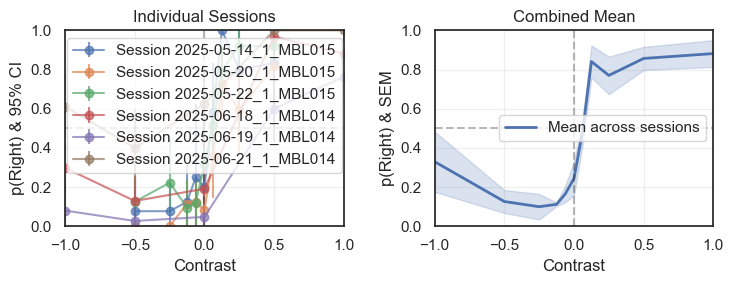

Figure saved in: C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/populationFigures\bias


In [43]:
# POPULATION ANALYSIS: Lateralised Choice BIAS Representation 
# Correlation between Choice-aligned neural activity (ipsi-contra) and bias

pfun.plot_ipsi_contra_vs_bias_correlation(
    recordingList=info.recordingList,
    bias_df=pfun.plot_combined_psychometric(info, save_path=None, return_df=True),
    time_window=[0.1, 0.8],
    bias_type='Choice Bias',
    alignment='choice',
    subfolder='responsive_neurons',
    save_path=bias_save_path
    )
print('Figure saved in: ' + bias_save_path)

In [ ]:
# Single-session Lateralised Stimulus BIAS representation

# Choice-aligned neural activity by biasStim for all sessions
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    if info.recordingList.imagingDataExtracted[ind] == 1:
        session_path = info.recordingList.analysispathname[ind]
        session_name = info.recordingList.sessionName[ind]
        subfolder = 'responsive_neurons'
        subfolder_path = os.path.join(session_path, subfolder)
        print(f"Plotting choice-aligned by bias for session: {session_name}")
        pfun.plot_event_aligned_by_bias_type(
            session_path,
            session_name,
            save_path=os.path.join(subfolder_path, 'bias'),
            bias_type='Stim Bias',
            alignment='stimulus'
        )

In [44]:
# POPULATION ANALYSIS: Lateralised Stimulus BIAS representation
# Stimulus-aligned neural activity by biasStim across sessions

pfun.plot_event_aligned_by_bias_type_across_sessions(
    recordingList=info.recordingList, 
    bias_type='Stim Bias', 
    alignment='stimulus', 
    subfolder='responsive_neurons', 
    save_path=bias_save_path
)
print('Figure saved in: ' + bias_save_path)

Figure saved in: C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/populationFigures\bias


In [45]:
# POPULATION ANALYSIS: Lateralised Stimulus BIAS Representation 
# Stimulus-aligned neural activity by biasStim across sessions - scatter plot of activity within a window of time

pfun.plot_event_aligned_bias_diff_scatter_window_across_sessions(
    recordingList=info.recordingList,
    time_window=[0.1, 0.8],
    bias_type='Stim Bias',
    alignment='stimulus',
    subfolder='responsive_neurons',
    save_path=bias_save_path
)
print('Figure saved in: ' + bias_save_path)

T-test Ipsi vs Contra: t = -0.047, p = 0.9633
Figure saved in: C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/populationFigures\bias


In [46]:
# POPULATION ANALYSIS: Lateralised Stimulus BIAS representation
# Stimulus-aligned neural activity by biasStimulus across sessions, one subplot by each contrast

pfun.plot_event_aligned_by_bias_type_across_sessions(
    recordingList=info.recordingList, 
    bias_type='Stim Bias', 
    alignment='stimulus', 
    subfolder='responsive_neurons', 
    save_path=bias_save_path,
    by_contrast=True
)
print('Figure saved in: ' + bias_save_path)

Figure saved in: C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/populationFigures\bias



Processing session: 2025-05-14_1_MBL015

Processing session: 2025-05-20_1_MBL015

Processing session: 2025-05-22_1_MBL015

Processing session: 2025-06-18_1_MBL014

Processing session: 2025-06-19_1_MBL014

Processing session: 2025-06-21_1_MBL014


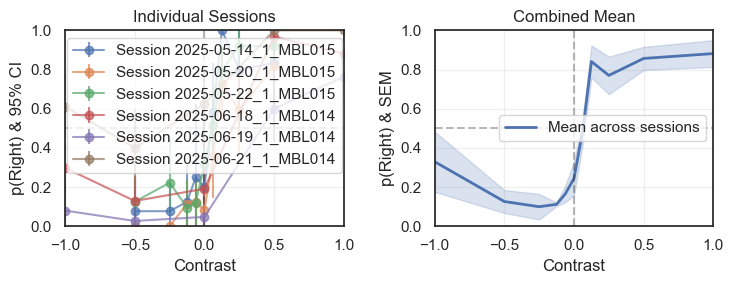

Figure saved in: C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/populationFigures\bias


In [47]:
# POPULATION ANALYSIS: Lateralised Stimulus BIAS Representation 
# Correlation between Stimulus-aligned neural activity (ipsi-contra) and bias

pfun.plot_ipsi_contra_vs_bias_correlation(
    recordingList=info.recordingList,
    bias_df=pfun.plot_combined_psychometric(info, save_path=None, return_df=True),
    time_window=[0.1, 0.8],
    bias_type='Stim Bias',
    alignment='stimulus',
    subfolder='responsive_neurons',
    save_path=bias_save_path
    )
print('Figure saved in: ' + bias_save_path)

In [49]:
# POPULATION ANALYSIS: Lateralised Stimulus BIAS Representation 
# Stimulus-aligned neural activity by biasStimulus across sessions - scatter plot of activity within a window of time by contrast

pfun.plot_event_aligned_stim_bias_diff_by_contrast_scatter_window_across_sessions(
    recordingList=info.recordingList,
    time_window=[0.1, 0.8],
    alignment='stimulus',
    subfolder='responsive_neurons',
    save_path=bias_save_path
)
print('Figure saved in: ' + bias_save_path)


Pairwise t-tests (adjacent contrasts):
Figure saved in: C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation/analysis/populationFigures\bias
